In [2]:
#Google Drive

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.  
drive.mount('/content/drive')

Mounted at /content/drive


In [51]:
import os, cv2, random
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
from keras.preprocessing import image

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from sklearn import preprocessing
from tensorflow.keras.applications.resnet50 import preprocess_input


Directory changed to specific folder which contains the dataset

In [52]:
os.chdir('/content/drive/MyDrive/Drunk Sober Classify/DeepLearning_Assignment_Drunk_Sober_Classify/')
!ls

 01_petros    13_manos	        25_nausika    37_vassilisA
 02_giorgos   14_lampros        26_tsag       38_christos
 03_vasil     15_konstantinos   27_theox      39_anna
 04_elpis     16_nikos	        28_frag       40_spiliop
 05_artemis   17_kwstas         29_lia	      41_kalp
 06_tris      18_dionisis       30_patty     'Problem Statement.docx'
 07_thanos    19_pasxalis       31_antonis    readme.docx
 08_tzon      20_nefeli         32_vicky      sample_data_read.ipynb
 09_giorg     21_ilias	        33_iliasv     VIMAL.doc
 10_konst     22_dimitris       34_alkis
 11_takis     23_vassiliskar    35_thanasis
 12_loukas    24_rig	        36_krod


In [53]:
#list folders are loaded into folders variable
folders = [f for f in os.listdir(os.getcwd()) if os.path.isdir(f)]
print('no. of folders:', len(folders))

no. of folders: 41


**VGG16 models are loaded for feature extraction**

In [55]:
from keras.applications.vgg16 import VGG16
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, AveragePooling2D, MaxPooling2D, Flatten, Reshape, Dropout
from keras.applications.vgg16 import preprocess_input
vgg_model = VGG16(weights='imagenet', include_top=True)
for layer in vgg_model.layers[:]:
  layer.trainable = False
#add fully connected layer which have 1024 neuron to vgg16 model
output = vgg_model.get_layer('fc2').output
output = Flatten (name='new_flatten')(output)
output = Dense(units = 1024, activation='relu',name='new_fc')(output)
#output = Dense(units=2, activation ='softmax')(output)
vgg_model =Model(vgg_model.input, output)

#make last 4 layers trainable if lastFourTrainabel ==True
#if lastFourTrainabel ==True
vgg_model.get_layer('block5_conv3').trainable = True
vgg_model.get_layer('fc1').trainable = True
vgg_model.get_layer('fc2').trainable = True
vgg_model.get_layer('new_fc').trainable = True

vgg_model.compile(optimizer = 'adam', loss='binary_crossentropy',metrics=['accuracy'])
vgg_model.summary()


553476096/553467096 [==============================] - 15s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

**ResNet50 model is loaded for feature extraction**

In [56]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.layers import Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, Reshape, Dropout
resnet_model = ResNet50(weights="imagenet", include_top=True)
#le = None
for layer in resnet_model.layers[:]:
  layer.trainable = False
#add fully connected layer which have 1024 neuron to resnet model
output = resnet_model.get_layer('avg_pool').output
#output = GlobalAveragePooling2D()(output)
output = Flatten (name='new_flatten')(output)
output = Dense(units = 1024, activation='relu',name='new_fc')(output)
#output = Dense(units=2, activation ='softmax')(output)
resnet_model =Model(resnet_model.input, output)

#make last 4 layers trainable if lastFourTrainabel ==True
#if lastFourTrainabel ==True
resnet_model.get_layer('conv5_block3_2_bn').trainable = True
resnet_model.get_layer('conv5_block3_3_conv').trainable = True
resnet_model.get_layer('conv5_block3_3_bn').trainable = True
resnet_model.get_layer('new_fc').trainable = True

resnet_model.compile(optimizer = 'adam', loss='binary_crossentropy',metrics=['accuracy'])
resnet_model.summary()



102981632/102967424 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_________________________

Predicts the feature using vgg16 model

In [57]:
def vgg_feature_ext(img_data):
  vgg16_feature = vgg_model.predict(img_data)
  
  return vgg16_feature

Predicts the feature using Resnet50 model

In [58]:
def resnet_feature_ext(img_data):
  resnet_feature = resnet_model.predict(img_data)

  return resnet_feature

Feature Extraction on images 

In [67]:
 
vgg_features_list = []
resnet_features_list = []
output_list=[]
for f in folders:
  image_files = os.listdir(os.path.join(os.getcwd(),f))
  for i in image_files:
    img = cv2.imread(os.path.join(f, i), cv2.IMREAD_UNCHANGED)
    #print("size of imaage is",img.shape)
    resized = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
    #print("resized imaage size ",resized.shape)
    backtorgb = cv2.cvtColor(resized,cv2.COLOR_GRAY2RGB)
    img_data = img_to_array(backtorgb)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    datagen = ImageDataGenerator(rotation_range = 40, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, brightness_range = (0.5, 1.5))
    x= i.split("_")
    #print(x[2])
    if int(x[2]) == 1:
      # prepare iterator
      it = datagen.flow(img_data, batch_size=1)
      
      for i in range(6):
        batch = it.next()
        image = batch[0].astype('uint8')
        
        img_data1 = img_to_array(image)
        img_data1 = np.expand_dims(img_data1, axis=0)
        img_data1 = preprocess_input(img_data1)
        
        vgg_features = vgg_feature_ext(img_data1)
        vgg_features_np = np.array(vgg_features)
        vgg_scaler = preprocessing.StandardScaler().fit(vgg_features_np)
        vgg_scaler.transform(vgg_features_np)
        vgg_final = vgg_features_np.flatten()
        vgg_features_list.append(vgg_final)

        resnet_features = resnet_feature_ext(img_data1)
        resnet_features_np = np.array(resnet_features)
        resnet_scaler = preprocessing.StandardScaler().fit(resnet_features_np)
        resnet_scaler.transform(resnet_features_np)
        resnet_final = resnet_features_np.flatten()
        resnet_features_list.append(resnet_final)

        output_list.append(0)
     
    else:
      # prepare iterator
      it = datagen.flow(img_data, batch_size=1)
      
      for i in range(2):
        batch = it.next()
        image = batch[0].astype('uint8')

        img_data1 = img_to_array(image)
        img_data1 = np.expand_dims(img_data1, axis=0)
        img_data1 = preprocess_input(img_data1)

        vgg_features = vgg_feature_ext(img_data1)
        vgg_features_np = np.array(vgg_features)
        vgg_scaler = preprocessing.StandardScaler().fit(vgg_features_np)
        vgg_scaler.transform(vgg_features_np)
        vgg_final = vgg_features_np.flatten()
        vgg_features_list.append(vgg_final)

        resnet_features = resnet_feature_ext(img_data1)
        resnet_features_np = np.array(resnet_features)
        resnet_scaler = preprocessing.StandardScaler().fit(resnet_features_np)
        resnet_scaler.transform(resnet_features_np)
        resnet_final = resnet_features_np.flatten()
        resnet_features_list.append(resnet_final)
        
        output_list.append(1)
     
output_list_np = np.array(output_list)
print(output_list_np.shape)

vgg_features_list_np = np.array(vgg_features_list)
resnet_features_list_np = np.array(resnet_features_list)
print("shape of vgg_features")
print(vgg_features_list_np.shape)
print("shape of resnet_features")
print(resnet_features_list_np.shape)


(1954,)
shape of vgg_features
(1954, 1024)
shape of resnet_features
(1954, 1024)


In [68]:
vgg_newf = vgg_features_list_np.copy()
resnet_newf = resnet_features_list_np.copy()
newo = output_list_np.copy()

**Training Models**

In [69]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score,confusion_matrix,classification_report
from sklearn.model_selection import learning_curve,StratifiedKFold
import seaborn as sns 
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn import tree

**Logistic Regression**


In [105]:
def logistic_regression(X_train, X_test, y_train, y_test):
  clf1 = LogisticRegression(max_iter=600).fit(X_train, y_train)
  print("training accuracy")
  print(clf1.score(X_train, y_train))
  print("Testing accuracy")
  print(clf1.score(X_test, y_test))

  y_pred2=clf1.predict(X_test)

  target_names = ['Sober', 'Drunk']
  print(classification_report(y_test, y_pred2, target_names=target_names))
  print('ROC-AUC:',round(roc_auc_score(y_test,y_pred2),4))
  # Confusion Matrix

  cm = confusion_matrix(y_test, y_pred2).T
  cm = cm.astype('float')/cm.sum(axis=0)
  ax = sns.heatmap(cm, annot=True, cmap='Blues');
  ax.set_xlabel('True Label',size=12)
  ax.set_ylabel('Predicted Label',size=12)

**MLP Classifier**

In [107]:
def MLP_Classifier(X_train, X_test, y_train, y_test):
  clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
  #clf.predict(X_test)
  y_pred=clf.predict(X_test)

  print("training accuracy")
  print(clf.score(X_train, y_train))
  print("Testing accuracy")
  print(clf.score(X_test, y_test))

  target_names = ['Sober', 'Drunk']
  print(classification_report(y_test, y_pred, target_names=target_names))
  print('ROC-AUC:',round(roc_auc_score(y_test,y_pred),4))
  # Confusion Matrix

  cm = confusion_matrix(y_test, y_pred).T
  cm = cm.astype('float')/cm.sum(axis=0)
  ax = sns.heatmap(cm, annot=True, cmap='Blues');
  ax.set_xlabel('True Label',size=12)
  ax.set_ylabel('Predicted Label',size=12)

**Decision Tree**

In [72]:
def Decision_Tree(X_train, X_test, y_train, y_test):
  
  model = tree.DecisionTreeClassifier()
  model.fit(X_train, y_train)
  print("training accuracy")
  print(model.score(X_train, y_train))
  print("Testing accuracy")
  print(model.score(X_test, y_test))

  y_pred1= model.predict(X_test)

  target_names = ['Sober', 'Drunk']
  print(classification_report(y_test, y_pred1, target_names=target_names))
  print('ROC-AUC:',round(roc_auc_score(y_test,y_pred1),4))
  # Confusion Matrix
 
  cm = confusion_matrix(y_test, y_pred1).T
  cm = cm.astype('float')/cm.sum(axis=0)
  ax = sns.heatmap(cm, annot=True, cmap='Blues');
  ax.set_xlabel('True Label',size=12)
  ax.set_ylabel('Predicted Label',size=12)


# Model using VGG features 


 Logistic regression Results
training accuracy
0.9756877799104287
Testing accuracy
0.618925831202046
              precision    recall  f1-score   support

       Sober       0.62      0.63      0.63       197
       Drunk       0.62      0.60      0.61       194

    accuracy                           0.62       391
   macro avg       0.62      0.62      0.62       391
weighted avg       0.62      0.62      0.62       391

ROC-AUC: 0.6188


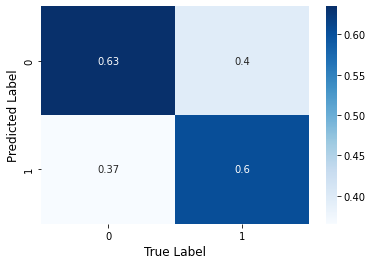

In [73]:
#training and testing data split
X_train, X_test, y_train, y_test = train_test_split(vgg_newf, newo, test_size=0.2, stratify=newo,random_state=42)
print("\n Logistic regression Results")
logistic_regression(X_train, X_test, y_train, y_test)




 Multi Layer Perceptron Classifier
training accuracy
1.0
Testing accuracy
0.659846547314578
              precision    recall  f1-score   support

       Sober       0.64      0.74      0.69       197
       Drunk       0.68      0.58      0.63       194

    accuracy                           0.66       391
   macro avg       0.66      0.66      0.66       391
weighted avg       0.66      0.66      0.66       391

ROC-AUC: 0.6593


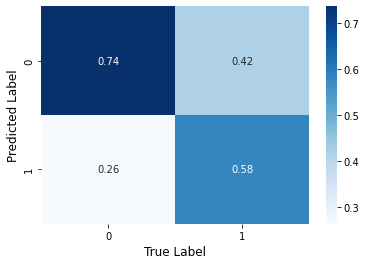

In [74]:
print("\n Multi Layer Perceptron Classifier")
MLP_Classifier(X_train, X_test, y_train, y_test)



 Decision Tree Classifier
training accuracy
1.0
Testing accuracy
0.5396419437340153
              precision    recall  f1-score   support

       Sober       0.54      0.55      0.55       197
       Drunk       0.54      0.53      0.53       194

    accuracy                           0.54       391
   macro avg       0.54      0.54      0.54       391
weighted avg       0.54      0.54      0.54       391

ROC-AUC: 0.5396


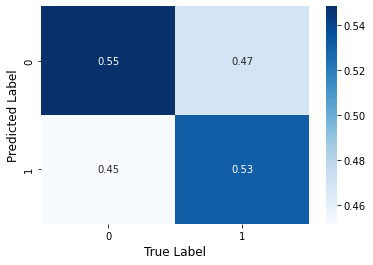

In [75]:

print("\n Decision Tree Classifier")
Decision_Tree(X_train, X_test, y_train, y_test)

# Model using Resnet Feature


 Logistic regression Results
training accuracy
0.9667306461932181
Testing accuracy
0.6240409207161125
              precision    recall  f1-score   support

       Sober       0.62      0.63      0.63       197
       Drunk       0.62      0.61      0.62       194

    accuracy                           0.62       391
   macro avg       0.62      0.62      0.62       391
weighted avg       0.62      0.62      0.62       391

ROC-AUC: 0.624


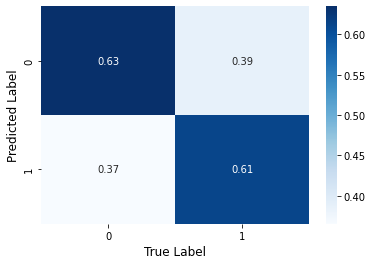

In [76]:
#training and testing data split
X_train, X_test, y_train, y_test = train_test_split(resnet_newf, newo, test_size=0.2, stratify=newo,random_state=42)
print("\n Logistic regression Results")
logistic_regression(X_train, X_test, y_train, y_test)




 Multi Layer Perceptron Classifier
training accuracy
1.0
Testing accuracy
0.690537084398977
              precision    recall  f1-score   support

       Sober       0.68      0.72      0.70       197
       Drunk       0.70      0.66      0.68       194

    accuracy                           0.69       391
   macro avg       0.69      0.69      0.69       391
weighted avg       0.69      0.69      0.69       391

ROC-AUC: 0.6903


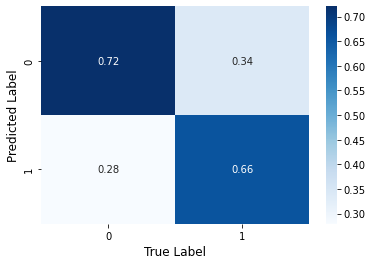

In [77]:
print("\n Multi Layer Perceptron Classifier")
MLP_Classifier(X_train, X_test, y_train, y_test)



 Decision Tree Classifier
training accuracy
1.0
Testing accuracy
0.5421994884910486
              precision    recall  f1-score   support

       Sober       0.54      0.57      0.56       197
       Drunk       0.54      0.52      0.53       194

    accuracy                           0.54       391
   macro avg       0.54      0.54      0.54       391
weighted avg       0.54      0.54      0.54       391

ROC-AUC: 0.542


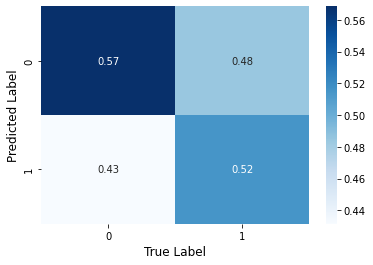

In [78]:

print("\n Decision Tree Classifier")
Decision_Tree(X_train, X_test, y_train, y_test)

# **Version 2**

**Feature Extraction without hand images**

In [79]:
vgg_features_list = []
resnet_features_list = []
output_list=[]
for f in folders:
  image_files = os.listdir(os.path.join(os.getcwd(),f))
  for i in image_files:
    x= i.split("_")
    if x[3]=='h':
      pass
    else:
      img = cv2.imread(os.path.join(f, i), cv2.IMREAD_UNCHANGED)
      #print("size of imaage is",img.shape)
      resized = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
      #print("resized imaage size ",resized.shape)
      backtorgb = cv2.cvtColor(resized,cv2.COLOR_GRAY2RGB)
      img_data = img_to_array(backtorgb)
      img_data = np.expand_dims(img_data, axis=0)
      img_data = preprocess_input(img_data)
      datagen = ImageDataGenerator(rotation_range = 40, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, brightness_range = (0.5, 1.5))
      #x= i.split("_")
      #print(x[2])
      if int(x[2]) == 1:
        # prepare iterator
        it = datagen.flow(img_data, batch_size=1)
        
        for i in range(6):
          batch = it.next()
          image = batch[0].astype('uint8')
          #img = cv2.imread(os.path.join(f, i), cv2.IMREAD_UNCHANGED)
          #print("size of imaage is",img.shape)
          #resized1 = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
          #print("resized imaage size ",resized.shape)
          #backtorgb1 = cv2.cvtColor(resized1,cv2.COLOR_GRAY2RGB)
          img_data1 = img_to_array(image)
          img_data1 = np.expand_dims(img_data1, axis=0)
          img_data1 = preprocess_input(img_data1)
          
          vgg_features = vgg_feature_ext(img_data1)
          vgg_features_np = np.array(vgg_features)
          vgg_scaler = preprocessing.StandardScaler().fit(vgg_features_np)
          vgg_scaler.transform(vgg_features_np)
          vgg_final = vgg_features_np.flatten()
          vgg_features_list.append(vgg_final)

          resnet_features = resnet_feature_ext(img_data1)
          resnet_features_np = np.array(resnet_features)
          resnet_scaler = preprocessing.StandardScaler().fit(resnet_features_np)
          resnet_scaler.transform(resnet_features_np)
          resnet_final = resnet_features_np.flatten()
          resnet_features_list.append(resnet_final)

          output_list.append(0)
      
      else:
        # prepare iterator
        it = datagen.flow(img_data, batch_size=1)
        
        for i in range(2):
          batch = it.next()
          image = batch[0].astype('uint8')

          #img = cv2.imread(os.path.join(f, i), cv2.IMREAD_UNCHANGED)
          #print("size of imaage is",img.shape)
          #resized1 = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
          #print("resized imaage size ",resized.shape)
          #backtorgb1 = cv2.cvtColor(resized1,cv2.COLOR_GRAY2RGB)
          img_data1 = img_to_array(image)
          img_data1 = np.expand_dims(img_data1, axis=0)
          img_data1 = preprocess_input(img_data1)

          vgg_features = vgg_feature_ext(img_data1)
          vgg_features_np = np.array(vgg_features)
          vgg_scaler = preprocessing.StandardScaler().fit(vgg_features_np)
          vgg_scaler.transform(vgg_features_np)
          vgg_final = vgg_features_np.flatten()
          vgg_features_list.append(vgg_final)

          resnet_features = resnet_feature_ext(img_data1)
          resnet_features_np = np.array(resnet_features)
          resnet_scaler = preprocessing.StandardScaler().fit(resnet_features_np)
          resnet_scaler.transform(resnet_features_np)
          resnet_final = resnet_features_np.flatten()
          resnet_features_list.append(resnet_final)
          
          output_list.append(1)
      

output_list_np = np.array(output_list)
print(output_list_np.shape)

vgg_features_list_np = np.array(vgg_features_list)
resnet_features_list_np = np.array(resnet_features_list)
print("shape of vgg_features")
print(vgg_features_list_np.shape)
print("shape of resnet_features")
print(resnet_features_list_np.shape)
   

(1466,)
shape of vgg_features
(1466, 1024)
shape of resnet_features
(1466, 1024)


In [80]:
vgg_newf = vgg_features_list_np.copy()
resnet_newf = resnet_features_list_np.copy()
newo = output_list_np.copy()

**Model using VGG feature and without hand images**


 Logistic regression Results
training accuracy
0.9914675767918089
Testing accuracy
0.5748299319727891
              precision    recall  f1-score   support

       Sober       0.58      0.57      0.58       148
       Drunk       0.57      0.58      0.57       146

    accuracy                           0.57       294
   macro avg       0.57      0.57      0.57       294
weighted avg       0.57      0.57      0.57       294

ROC-AUC: 0.5748


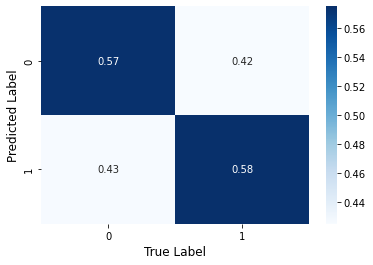

In [81]:
#training and testing data split
X_train, X_test, y_train, y_test = train_test_split(vgg_newf, newo, test_size=0.2, stratify=newo,random_state=42)
print("\n Logistic regression Results")
logistic_regression(X_train, X_test, y_train, y_test)




 Multi Layer Perceptron Classifier
training accuracy
1.0
Testing accuracy
0.608843537414966
              precision    recall  f1-score   support

       Sober       0.61      0.60      0.61       148
       Drunk       0.60      0.62      0.61       146

    accuracy                           0.61       294
   macro avg       0.61      0.61      0.61       294
weighted avg       0.61      0.61      0.61       294

ROC-AUC: 0.6089


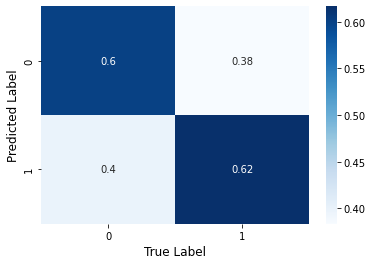

In [82]:
print("\n Multi Layer Perceptron Classifier")
MLP_Classifier(X_train, X_test, y_train, y_test)



 Decision Tree Classifier
training accuracy
1.0
Testing accuracy
0.5374149659863946
              precision    recall  f1-score   support

       Sober       0.54      0.49      0.52       148
       Drunk       0.53      0.58      0.56       146

    accuracy                           0.54       294
   macro avg       0.54      0.54      0.54       294
weighted avg       0.54      0.54      0.54       294

ROC-AUC: 0.5377


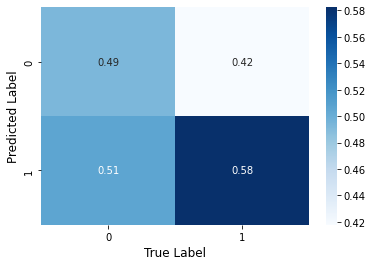

In [83]:

print("\n Decision Tree Classifier")
Decision_Tree(X_train, X_test, y_train, y_test)

**Model using Resnet feature and without hand images**


 Logistic regression Results
training accuracy
0.9872013651877133
Testing accuracy
0.7040816326530612
              precision    recall  f1-score   support

       Sober       0.70      0.73      0.71       148
       Drunk       0.71      0.68      0.69       146

    accuracy                           0.70       294
   macro avg       0.70      0.70      0.70       294
weighted avg       0.70      0.70      0.70       294

ROC-AUC: 0.7039


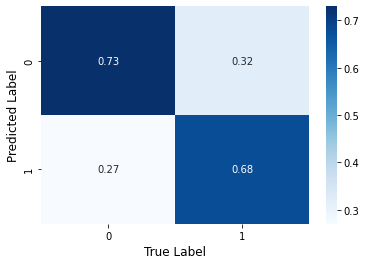

In [109]:
#training and testing data split
X_train, X_test, y_train, y_test = train_test_split(resnet_newf, newo, test_size=0.2, stratify=newo,random_state=42)
print("\n Logistic regression Results")
logistic_regression(X_train, X_test, y_train, y_test)




 Multi Layer Perceptron Classifier
training accuracy
1.0
Testing accuracy
0.6870748299319728
              precision    recall  f1-score   support

       Sober       0.67      0.74      0.71       148
       Drunk       0.71      0.63      0.67       146

    accuracy                           0.69       294
   macro avg       0.69      0.69      0.69       294
weighted avg       0.69      0.69      0.69       294

ROC-AUC: 0.6867


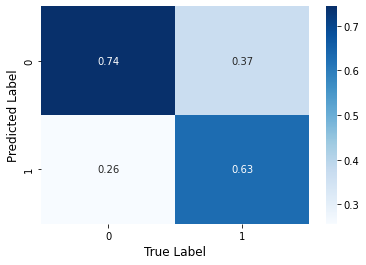

In [108]:
print("\n Multi Layer Perceptron Classifier")
MLP_Classifier(X_train, X_test, y_train, y_test, )




 Decision Tree Classifier
training accuracy
1.0
Testing accuracy
0.5850340136054422
              precision    recall  f1-score   support

       Sober       0.58      0.61      0.60       148
       Drunk       0.59      0.56      0.57       146

    accuracy                           0.59       294
   macro avg       0.59      0.58      0.58       294
weighted avg       0.59      0.59      0.58       294

ROC-AUC: 0.5849


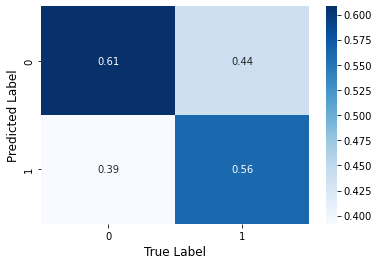

In [86]:
print("\n Decision Tree Classifier")
Decision_Tree(X_train, X_test, y_train, y_test)